# <font color='yellow'> Apprendimento automatico [AA-2425] </font>

## Esercizio 15.03.2025
_Lavorato da Anisa Bakiu_

**Richiesta**: Usare un dataset fatto di immagini, dove le features sono i valori di singoli pixel. 

# Pipeline del modello Naïve Bayes

Il dataset scelto è il dataset di immagini [`load_digits`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) <br>
Ogni esempio è un'immagine 8x8 di una cifra. Questa è una copia del dataset di cifre scritte a mano di [UCI ML](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits). 

In [83]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict

# Carico il dataset
digits = datasets.load_digits()

## Esplorazione dei dati

In [18]:
print(f"Shape of X (features): {digits.data.shape}")  
print(f"Shape of y (labels): {digits.target.shape}")  

Shape of X (features): (1797, 64)
Shape of y (labels): (1797,)


Distribuzione delle classi, per capire se nel dataset ci sono classi sbilanciate.

In [19]:
unique, counts = np.unique(digits.target, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

Class distribution: {0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


Visualizzazione di alcune immagini in grey scale.

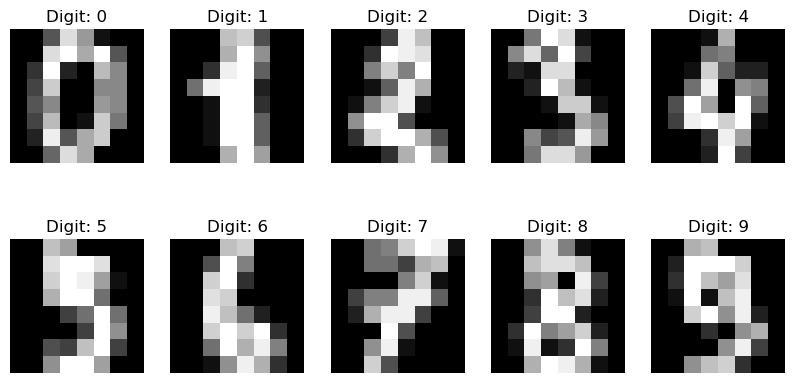

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f"Digit: {digits.target[i]}")
    axes[i].axis('off')

plt.show()

Comprendere le statistiche sull'intervallo dei valori dei pixel

In [21]:
print(f"Min pixel value: {np.min(digits.data)}")
print(f"Max pixel value: {np.max(digits.data)}")
print(f"Mean pixel value: {np.mean(digits.data):.2f}")

Min pixel value: 0.0
Max pixel value: 16.0
Mean pixel value: 4.88


## Implementazione del modello Naïve Bayes

In Naïve Bayes, l'ipotesi è che ogni feature sia condizionatamente indipendente **data la classe**. Quindi, il modello assume matrici di covarianza diagonali (le features non sono correlate) e la likelihood per ogni $x_i$ diventa il prodotto delle singole distribuzioni gaussiane univariate.

$$ P(x_i \mid c) = \frac{1}{\sqrt{2\pi \sigma_{i,c}^2}} \exp \left( -\frac{(x_i - \mu_{i,c})^2}{2 \sigma_{i,c}^2} \right)
$$

Facendo l'assunzione che i dati seguono una distribuzione continua, scelgo di utilizzare il modello Gaussian Naïve Bayes [`GaussianNB()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). 

In [88]:
X, y = digits.data, digits.target  

In [85]:
# Definisco il modello
nb = GaussianNB()

# 5-Fold Cross-Validation ripetuto 10 volte
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Misura il tempo di esecuzione
start_time = time.time()

# Scelgo accuracy come misura di prestazione
scores = cross_val_score(nb, X, y, cv=cv, scoring='accuracy')

# Calcolo il tempo richiesto
end_time = time.time()
execution_time = end_time - start_time

In [86]:
# Calcolo la media di Accuracy e sqm
print(f"Mean Accuracy: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")
print(f"Execution time: {execution_time:.4f} seconds")

Mean Accuracy: 0.8389
Standard Deviation: 0.0248
Execution time: 0.2435 seconds


# Regressione Logistica

## Cenni teorici

Dato il confronto teorico fatto durante le lezioni tra questi 2 modelli, ho deciso di effettuare anche un confronto pratico per verificare quale dei due ottiene le migliori prestazioni su questo dataset. (Non migliore in assoluto $\rightarrow$ _No free lunch theorem_)

La regressione logistica inizia con la funzione sigmoide ovvero la funzione logistica standard. Restituisce valori tra 0 e 1, adatti alla modellizzazione della probabilita'. Di seguito è riportata l'equazione sigmoide:

$$\sigma(t) = \frac{1}{1+e^{-t}}$$

dove: $t = w_o + w_1x_1 + w_2x_2$$ +...$ combinazione di feature di input e pesi del modello, calcolati utilizzando la stima di massima verosimiglianza.

La regolarizzazione L2 utilizza l'equazione menzionata di seguito, dove il valore Lambda $\lambda$ è utilizzato per la regolarizzazione.

$$\mathcal{L}(\boldsymbol{\mathbf{w}}) = \displaystyle\sum_{i = 1}^{N}log(1+exp(-y_i\boldsymbol{\mathbf{w}}^Tx_i))+\frac{\lambda}{2}\|\boldsymbol{\mathbf{w}}\|_2$$

Il classificatore 1 vs All addestra un modello di classificazione binaria per ciascuna classe.  Per il nostro problema dobbiamo creare 10 classificatori di questo tipo, in cui ciascun classificatore distingue una singola cifra dalle altre.

Dopo aver creato 10 classificatori, viene creato il classificatore 1 contro tutti per ottenere la probabilità della cifra 1 rispetto a tutte le altre classi. Viene scelta la probabilità massima tra tutti i 10 classificatori per fornire la previsione della classe dell'immagine data.

Per ottimizzare il classificatore di regressione logistica, utilizziamo la discesa del gradiente per minimizzare la loss function e scegliere il miglior valore per i pesi $w$.

Dopo aver calcolato il gradiente della loss function, otteniamo:

$$\nabla \mathcal{L}(\mathbf{w}) = \displaystyle\sum\frac{-y_i\mathbf{w^T}x_i}{1+exp(-y_iw^{\bar{T}}x_i)}+\lambda \mathbf{w}$$

consegue che: $$\mathbf{w}_{t+1} = w - \eta \nabla_L(w)$$

## Implementazione del modello

In [87]:
# Import del package di regressione logistica
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# Definisco il modello
lr = LogisticRegression(max_iter=10000, random_state=42)

# 5-Fold Cross-Validation ripetuto 10 volte
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Misura il tempo di esecuzione
start_time = time.time()

# Usa l'accuracy come misura di prestazione
scores = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')

# Calcolo il tempo di esecuzione
end_time = time.time()
execution_time = end_time - start_time

# Mostra i risultati
print(f"Mean accuracy:, {scores.mean():.4f}")
print(f"Standard deviation accuracy:, {scores.std():.4f}")
print(f"Execution time: {execution_time:.4f} seconds")

Mean accuracy:, 0.9652
Standard deviation accuracy:, 0.0088
Execution time: 18.0679 seconds


Nota: regularization is applied by default. [doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

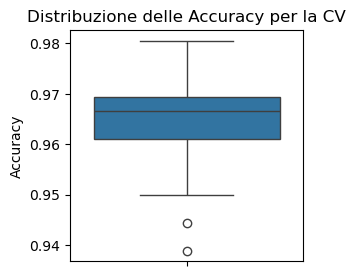

In [69]:
# Grafico Boxplot per la distribuzione delle accuratezze
plt.figure(figsize=(3, 3))
sns.boxplot(data=scores)
plt.title("Distribuzione delle Accuracy per la CV")
plt.ylabel("Accuracy")
plt.show()

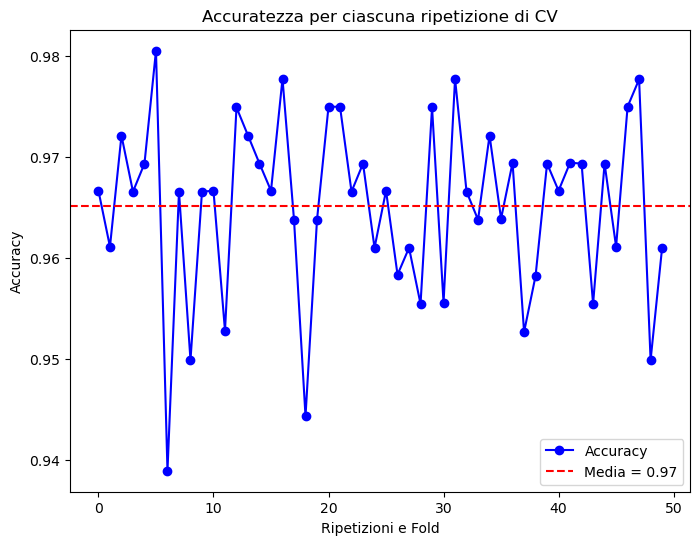

In [75]:
# Grafico della media delle Accuratezze
plt.figure(figsize=(8, 6))
plt.plot(scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.axhline(y=scores.mean(), color='r', linestyle='--', label=f'Media = {scores.mean():.2f}')
plt.title("Accuratezza per ciascuna ripetizione di CV")
plt.xlabel("Ripetizioni e Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Conclusioni

Per il dataset considerato `load_digits`, il modello di regressione logistica risulta essere la scelta migliore, in quanto utilizzando la tecnica di Cross Validation 5 fold ripetuto 10 volte, otteniamo un'accuracy (%) del **96.5 $\pm$ 0.8**. Utilizzando Naïve Bayes l'accuracy (%) e' dell'**83.4 $\pm$ 2.4**. 
- Lo svantaggio della regressione logistica e' il tempo di esecuzione pari a `18.0679 seconds`, maggiore rispetto a Naïve Bayes, che impegna solo `0.2435 seconds`. 